In [2]:
import os
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
import csv

## Download Data

### Define the boundaries (the PNSN query)

In [3]:
def read_dataset():
    df = pd.read_csv('https://media.githubusercontent.com/media/Benz-Poobua/ESS-469-Project/main/bulk_event_magnitude_phase_nwf_FV.csv', parse_dates=['datetime', 'arrdatetime'], index_col=[0])
    df.index = df.arid
    # Explicitly (re)define the bounding box used for the PNSN catalog query
    latll, lonll = 42.0, -125.5
    latur, lonur = 49.0, -122.0
    t0, t1 = UTCDateTime(2015,1,1), UTCDateTime(2023,11,17)
    df= df[
        (df.lat >= latll)
        & (df.lat <= latur)
        & (df.lon >= lonll)
        & (df.lon <= lonur)
    ]
    feature_df = df.copy().iloc[:, -140:]
    data_arr = np.empty((0, 140), dtype=np.float16)
    target_arr = np.empty((0, 1), dtype=np.float16)
    # dataframe of the last 140 columns to numpy array
    for i in df.arid.unique():
        data_arr = np.append(data_arr, np.array([feature_df.loc[i]], dtype=np.float16), axis=0)
        target_arr = np.append(target_arr, np.array([[df.loc[i].magnitude]], dtype=np.float16), axis=0)
    return data_arr, target_arr

In [4]:
# Save the array to file so it is easier to load for future use
def save_array(filename, arr):
    # save the array to a file
    np.save(filename, arr)

In [5]:
# Defined function to import numpy array for future use
def import_array(filename):
    # import the array from the file
    arr = np.load(filename)
    return arr

In [6]:
# check if the file exists
if os.path.isfile('bulk_event_magnitude_phase_nwf_FV.npy') and os.path.isfile('bulk_event_magnitude_phase_nwf_FV_target.npy'):
    data_arr = import_array('bulk_event_magnitude_phase_nwf_FV.npy')
    target_arr = import_array('bulk_event_magnitude_phase_nwf_FV_target.npy')
else:
    data_arr, target_arr = read_dataset()
    save_array('bulk_event_magnitude_phase_nwf_FV.npy', data_arr)
    save_array('bulk_event_magnitude_phase_nwf_FV_target.npy', target_arr)

In [7]:
X = data_arr # feature vectors
y = target_arr # magnitude

In [8]:
print(X.shape)
print(y.shape)

(65821, 140)
(65821, 1)


## Data Cleanning

In [9]:
# Identify and handle infinite values in X
inf_indices_X= np.isinf(X)

# Replace infinite values with a suitable value (e.g., NaN)
X[inf_indices_X] = np.nan  # Replace with NaN

# Find indices of rows with NaN values in X
nan_indices_X = np.any(np.isnan(X), axis=1)

# Remove rows with NaN values from X and y
X_no_nan = X[~nan_indices_X]
y_no_nan = y[~nan_indices_X]

In [10]:
X_no_nan.shape

(65766, 140)

In [11]:
y_no_nan.shape

(65766, 1)

## Data Splitting

### 80% train set + 20% test set

In [16]:
# Splitting the data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_no_nan, y_no_nan, test_size=0.2, random_state=42)

Check shapes of arrays, the x must be (x, 140) and y must (x, 1) x should be equal for both training and testing sets

In [17]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(52612, 140)
(13154, 140)
(52612, 1)
(13154, 1)


## Data Distribution

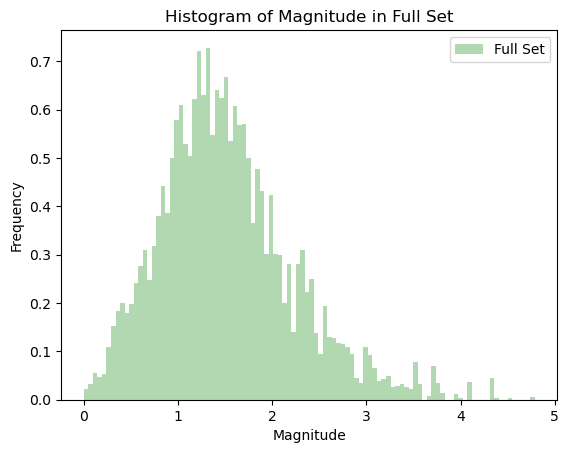

In [85]:
plt.hist(y, bins=100, density=True, alpha=0.3, color='green', label='Full Set')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Magnitude in Full Set')
plt.show()

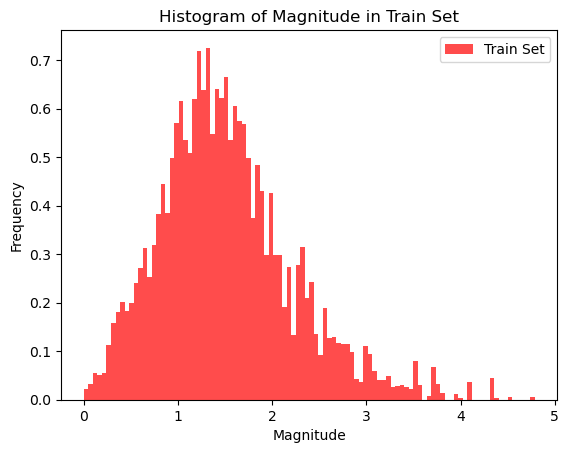

In [86]:
plt.hist(y_train, bins=100, density=True, alpha=0.7, color='red', label='Train Set')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Magnitude in Train Set')
plt.show()

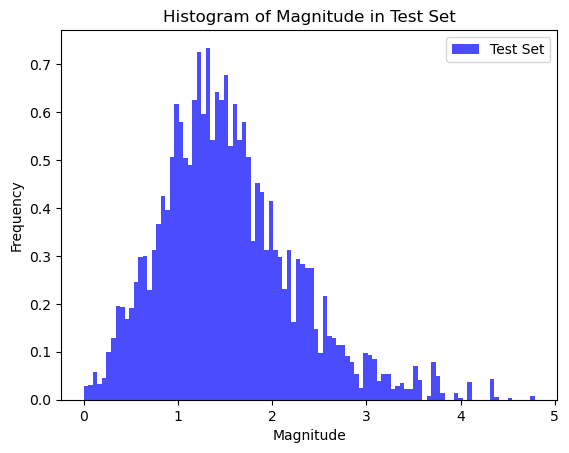

In [88]:
plt.hist(y_test, bins=100, density=True, alpha=0.7, color='blue', label='Test Set')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Magnitude in Test Set')
plt.show()

## K-fold Cross Validation + Base model

### XGBoost as Base model
OOF predictions are used as input for the meta model.

In [20]:
from sklearn.model_selection import cross_val_score, KFold,cross_val_predict
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [21]:
# K-fold cross-validation setting
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=False)

In [22]:
# collect OOF predictions
data_X, data_y, xgb_yhat = list(), list(), list()

In [23]:
for train_ix, test_ix in kfold.split(X_train):
    #get data
    train_X, test_X = X[train_ix], X[test_ix]
    train_y, test_y = y[train_ix], y[test_ix]
    data_X.extend(test_X)
    data_y.extend(test_y)
    model_xgb = make_pipeline(StandardScaler(), xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                                                             learning_rate=0.05, max_depth=4, min_child_weight=1.7817,
                                                             n_estimators=6000,reg_alpha=0.4640, reg_lambda=0.8571, 
                                                             subsample=0.8, verbosity=0, nthread=-1))
    model_xgb.fit(train_X, train_y)
    yhat = model_xgb.predict(test_X)
    xgb_yhat.extend(yhat)

In [24]:
len(xgb_yhat)

52612

## Meta model
### Lasso as Meta model

Define new input

In [36]:
# create a meta dataset
def create_meta_dataset(data_X, xgb_yhat):
 # convert to columns
 xgb_yhat = np.array(xgb_yhat).reshape((len(xgb_yhat), 1))
 # stack as separate columns
 meta_X = np.hstack((data_X, xgb_yhat))
 return meta_X

In [37]:
# construct meta dataset
meta_X = create_meta_dataset(data_X, xgb_yhat)

In [68]:
print(meta_X.shape)
print(len(data_y))
print(len(data_X))
print(len(xgb_yhat))

(52612, 141)
52612
52612
52612


Do additional data cleanning (Nan)

In [69]:
data_y_array = np.array(data_y)
# Find indices of rows with NaN values in meta_X
nan_indices_meta_X = np.any(np.isnan(meta_X), axis=1)
# Remove rows with NaN values from X and y
meta_X_no_nan = meta_X[~nan_indices_meta_X]
data_y_array_no_nan = data_y_array[~nan_indices_meta_X]


Convert array to list for Lasso fit

In [64]:
data_y_no_nan_list = data_y_array_no_nan.tolist()

Train the meta model

In [67]:
from sklearn.linear_model import LassoCV
meta_model = LassoCV(cv=10)
meta_model.fit(meta_X_no_nan, data_y_no_nan_list)

/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV(cv=10)

In [79]:
# make predictions with stacked model
def stack_prediction(model, meta_model, X):
 # make predictions
 yhat = model.predict(X)
 # create input dataset
 meta_X = create_meta_dataset(X, yhat)
 # predict
 return meta_model.predict(meta_X)

In [80]:
from sklearn.metrics import mean_absolute_error
# evaluate sub models on hold out dataset
XGB_MAE = mean_absolute_error(y_test, model_xgb.predict(X_test))
print('XGB MAE: %.3f' % XGB_MAE)

XGB MAE: 0.196


In [81]:
# evaluate meta model on hold out dataset
yhat = stack_prediction(model_xgb, meta_model, X_test)
Meta_MAE = mean_absolute_error(y_test, yhat)
print('Meta MAE: %.3f' % Meta_MAE)

Meta MAE: 0.200


# Plotting model results

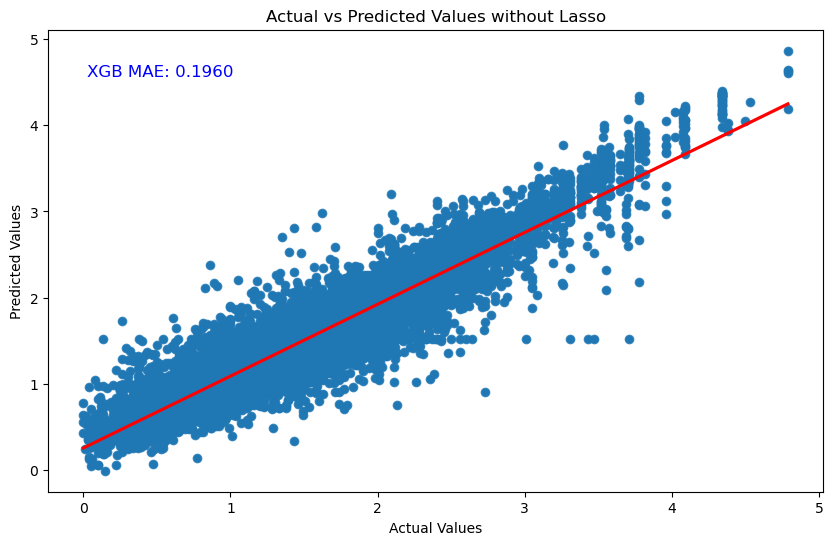

In [82]:
import seaborn as sns
# Convert y_test to a 1D array
y_test_array = y_test.values.flatten() if isinstance(y_test, pd.DataFrame) else y_test.flatten()

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_array, y=model_xgb.predict(X_test))
sns.regplot(x=y_test_array, y=model_xgb.predict(X_test), line_kws={'color': 'red'})
plt.title('Actual vs Predicted Values without Lasso')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.annotate(f'XGB MAE: {XGB_MAE:.4f}', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12, color='blue')
plt.show()

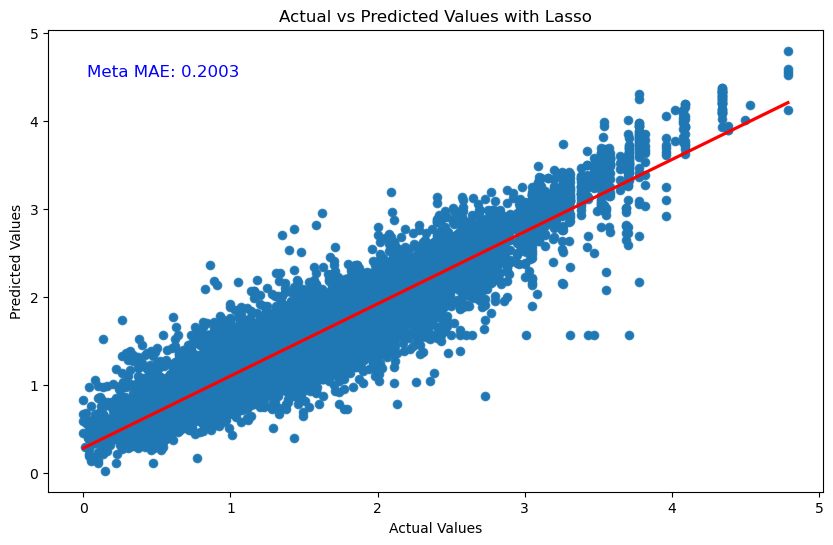

In [83]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_array, y= yhat)
sns.regplot(x=y_test_array, y= yhat, line_kws={'color': 'red'})
plt.title('Actual vs Predicted Values with Lasso')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.annotate(f'Meta MAE: {Meta_MAE:.4f}', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12, color='blue')
plt.show()